<a href="https://colab.research.google.com/github/Nayrobie/DMML2022_Apple/blob/main/DMML2022_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Kaggle Competition & Project Introduction

#### Detecting the difficulty level of French texts


## 🚀 About the project 


During our Master class, Data mining and machine learning, we have joined a competition on [Kaggle.](https://Kaggle.com)com. The goal was to build a model for English speakers that predicts the difficulty of a French written text between A1 to C2.

### Description of the project 


First of all, we have identified a problem that many language learners face: it is often difficult to find texts that are at an appropriate level of difficulty for their current language skills. With this in mind, we have developed a model that predicts the difficulty of French texts, with the goal of helping language learners find texts that are at an appropriate level of difficulty for their skill level.

The data that we used to build our model includes : labeled training data and unlabelled test data. The variety techniques that we used include : logistic regression, kNN, decision trees, random forests, and other techniques, to build and train our model. In order to find better solution, we have also performed hyper-parameter optimisation like grid Search. In evaluating our model, we have considered various metrics, including precision, recall, F1-score, and accuracy.

We are excited to share our solution with you and hope that it will be useful for language learners looking for texts at the right level of difficulty. We invite you to try out our model and see how it performs. 

## 🏗️ Build with 


To construct this model, we used three dataset that we found on kaggle.com.


- **training_data.csv** - the training set with 4800 uniques values 
- **unlabelled_test_data.csv** - the test set with 1200 unique values
- **sample_submission.csv** - a sample submission file in the correct format

## Contributors 

- Yonah Bôle
- Simon Demont

### Importing Main Libraries

In [ ]:
# Import required packages
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn. preprocessing import StandardScaler

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [62]:
#import spaCy with french model
!pip install -U spacy
!python -m spacy download fr_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-22 17:10:50.454775: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 211 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


### 1. Train the model & compute the baseline

To begin with, we set our X and y variables and
split the data into a train and test set.

In [ ]:
# Import the csv datasets
df_train, df_pred =  pd.read_csv('training_data.csv'),pd.read_csv('unlabelled_test_data.csv')

Below is an overview of the dataset that will be used for this project:

- df_train contains 4800 sentences with their language dfficulty level (0 to 5 for A1 to C2)
- df_pred is an example thats shows how to upload our results on the Kaggle competition, it contains 1200 rows and only the sentences id and the difficulty level (A1 to C2)

In [ ]:
df_train_rows, df_train_cols = df_train.shape
print("Number of rows:", df_train_rows,"\nNumber of columns:", df_train_cols)
df_train.head()

Number of rows: 4800 
Number of columns: 3


,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,4
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",0
2,2,Le test de niveau en français est sur le site ...,0
3,3,Est-ce que ton mari est aussi de Boston?,0
4,4,"Dans les écoles de commerce, dans les couloirs...",2


In [ ]:
df_pred_rows, df_pred_cols = df_pred.shape
print("Number of rows:", df_pred_rows,"\nNumber of columns:", df_pred_cols)
df_pred.head()

Number of rows: 1200 
Number of columns: 2


,id,difficulty
0,0,C2
1,1,B1
2,2,A1
3,3,A1
4,4,C2


In [ ]:
# Set the regression variables
y = df_train['difficulty'] # dependent var
X = df_train['sentence'] # independent var

# Split train test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0)

Then we computed what is the baseline percentage for this classification problem. 

This baseline serves as a minimum performance standard that we can use to compare the performance of other models we will use later in the project. In order to be considered for use, these models must all return higher accuracy scores than the baseline model. This allows us to determine whether the new models are actually improving upon the baseline.

In [ ]:
# Base Rate = (most frequent class) / (total observations)
from sklearn.dummy import DummyClassifier

# Find most frequent class
dummy = DummyClassifier(strategy='most_frequent')

# Fit it as if we had no X features to train it on
dummy.fit(None, y_train)

# Compute test baseline
baseline = dummy.score(None, y_test)

# Show the result in a DataFrame
baseline_df = pd.DataFrame({'baseline_%': baseline}, index=[0])*100
baseline_df.round(decimals=2)

,baseline_%
0,16.77


### 2.1 Logistic Regression

In section 2, we want to try different regression models on our dataset without data cleaning. We will then proceed to compare how well the different models performed and which one gave us the best accuracy result without data cleaning. To compare the models, we chose to use the most relevent metrics: accuracy, precision, recall and F1 score.

The first model we tried is a Logistic Regression using a Tfidf vectoriser.

In [ ]:
def convert_difficulty(df, reverse=False):
  """ 
  The function converts the difficulty column of the dataset from the language level (A1 to C2) to a scale from 0 to 5, or vice versa.
  To use it, enter a Pandas DataFrame (df) and say if you want to convert the difficulty column to a scale of 0 to 5 (reverse=False) 
  or reconvert it back to language level (reverse=True).
  """
  if not reverse:
    df.loc[df['difficulty']=='A1','difficulty']=0
    df.loc[df['difficulty']=='A2','difficulty']=1
    df.loc[df['difficulty']=='B1','difficulty']=2
    df.loc[df['difficulty']=='B2','difficulty']=3
    df.loc[df['difficulty']=='C1','difficulty']=4
    df.loc[df['difficulty']=='C2','difficulty']=5
  else:
    df.loc[df['difficulty']==0,'difficulty']='A1'
    df.loc[df['difficulty']==1,'difficulty']='A2'
    df.loc[df['difficulty']==2,'difficulty']='B1'
    df.loc[df['difficulty']==3,'difficulty']='B2'
    df.loc[df['difficulty']==4,'difficulty']='C1'
    df.loc[df['difficulty']==5,'difficulty']='C2'


In [ ]:
# Convert the difficulty level from language level to 0 to 5 scale
convert_difficulty(df_train, reverse=False)

# Split data in X and Y
y = df_train['difficulty'] # dependent var
X = df_train['sentence'] # independent var

# Split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y)
# Transfrom 'difficulty' label to integer 
y_test = y_test.astype('int')
y_train = y_train.astype('int')

In [ ]:
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

tfidf_vector = TfidfVectorizer()

def evaluate_model(name, classifier, X_train, y_train, X_test, y_test):
    """
    This function evaluates a classification model and returns the most important metrics: the model accuracy, precision, recall and F1 scores.
    To use it, enter a name for your model (str), the classifier used, and then the features of the testing and training set.
    """
    # First the vectoriser transform the input data into numerical data
    # Then the classifier use this data to train a model and predict the result of the evaluation
    pipe = Pipeline([('vectorizer', tfidf_vector),
                     ('classifier', classifier)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    report = classification_report(y_test, y_pred, digits=6, output_dict=True)
    
    # We then extract the most relevant metrics from the classification_report
    results = {
        'model': name,
        'accuracy': round(report['accuracy'], 6),
        'precision': round(report['1']['precision'], 6),
        'recall': round(report['1']['recall'], 6),
        'f1_score': round(report['1']['f1-score'], 6)
    }
    # To return them as the output of our function
    return results

In [ ]:
# For the logistic regression
log_reg = LogisticRegression(random_state=0)

# Evaluate the logistic regression
report_logistic = evaluate_model('Logistic Regression',
                                 log_reg,
                                 X_train, y_train, X_test, y_test)
report_logistic

{'model': 'Logistic Regression',
 'accuracy': 0.460417,
 'precision': 0.451389,
 'recall': 0.408805,
 'f1_score': 0.429043}

We then had a look at the multi-class confusion matrix and identified a few examples of sentences that are not well classified with our model.

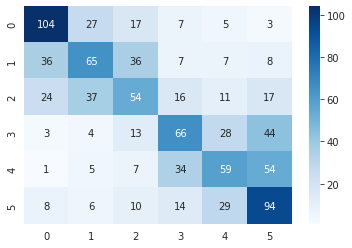

In [ ]:
import seaborn as sns

pipe = Pipeline([('vectorizer', tfidf_vector),('classifier', log_reg)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# To plot the confusion matrix
sns.set_style("whitegrid")
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred)), annot=True, cmap='Blues', fmt='.4g')

The multi-class confusion matrix above shows how well the Logistic Regression model performed, how much predictions it did were right.

The matrix below shows where the TP, TN, FP, FN are for a multi-class (non-binary) classification problem.

<img src="https://pictshare.net/z2lpl2.png" alt="matrix" width="300"/>

So for our problem, we can see that the Logistic Regression model is better a predicting the language level for sentences that are written in a very good level (5 is for C2) and a very low one (0 is for A1), as it's were the matrix has more TP.

In [ ]:
# Here are a few examples of sentences that were not well classified
X_test[y_test !=y_pred].head()

2003    Il est également connu pour ses publicités tél...
2585    Edgar, étincelant de furie, dominait tous les ...
2302                                    Ils sont heureux.
2958    Les canons renversèrent d'abord à peu près six...
3862    Parce que la philosophie se trouve de plus en ...
Name: sentence, dtype: object

We now proceeded to upload our first submission on the Kaggle competition we the accuracy of our first Logistic Regression model without data cleaning.

In [ ]:
# Generate a first prediction
# Add prediction in df_pred as 'difficulty' column
df_pred['difficulty'] = pipe.predict(df_pred['sentence'])

# Transform column 'difficulty' back to language level
convert_difficulty(df_pred, reverse=True)

# Show a few predictions
df_pred.head()

,id,sentence,difficulty
0,0,Nous dûmes nous excuser des propos que nous eû...,C2
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...,B1
2,2,"Et, paradoxalement, boire froid n'est pas la b...",A1
3,3,"Ce n'est pas étonnant, car c'est une saison my...",A1
4,4,"Le corps de Golo lui-même, d'une essence aussi...",C2


In [ ]:
# To make our first submission to the Kaggle competition
# Rename the dataframe
df_pred_submission = df_pred

# Delete columns 'sentence' to fit the submission format for kaggle 
df_pred_submission.pop('sentence')

# Show the df in the good format
df_pred_submission.head()

,id,difficulty
0,0,C2
1,1,B1
2,2,A1
3,3,A1
4,4,C2


In [ ]:
# Save a csv file to upload on Kaggle
df_pred_submission.to_csv('UNIL_Apple_submission.csv',index=False)

### 2.2. K-nearest neighbour model

The second model we tested is the KNN model.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# For the basic KNN model
knn = KNeighborsClassifier()

# Evaluate the KNN model
report_knn = evaluate_model('K-Nearest Neighbour',knn,X_train, y_train, X_test, y_test)
report_knn

{'model': 'K-Nearest Neighbour',
 'accuracy': 0.315625,
 'precision': 0.26484,
 'recall': 0.36478,
 'f1_score': 0.306878}

We tried to improve the accuracy by tuning the hyper parameters `n_neighbors`, `p`, and `weights` with different methods:
- first the grid search with cross-validation returned `n_neighbors`: 3, `p`: 2, `weights`: 'distance' 
- second the randomised search returned most of the time `n_neighbors`: 11, `p`: 2, `weights`: 'distance' 
- then we tried by trials & errors and tested `n_neighbors`: 5, `p`: 2, `weights`: 'distance'

In [ ]:
# Improve the metrics with grid search and cross-validation
from sklearn.model_selection import GridSearchCV

# Vectorise the sentences & convert y to integer
X_vectorised = X.copy()
X_vectorised = tfidf_vector.fit_transform(X_vectorised)
y_int = y.astype('int')

# Look for best parameters with grid search CV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_vectorised, y_int)

print(grid_search.best_params_)

{'n_neighbors': 3, 'weights': 'distance'}


In [ ]:
# With the Grid Search CV parameters
knn_best_parameters_grid = KNeighborsClassifier(n_neighbors=3, weights="distance")

report_knn_grid_CV = evaluate_model('KNN Grid Search CV',knn_best_parameters_grid,X_train, y_train, X_test, y_test)
report_knn_grid_CV

{'model': 'KNN Grid Search CV',
 'accuracy': 0.361458,
 'precision': 0.30622,
 'recall': 0.402516,
 'f1_score': 0.347826}

In [ ]:
# Improve the metrics with randomised search and cross-validation 
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance']
}

random_search = RandomizedSearchCV(knn, param_dist, cv=5, scoring='accuracy')
random_search.fit(X_vectorised, y_int)

print(random_search.best_params_)

{'weights': 'distance', 'n_neighbors': 3}


In [ ]:
# With the Random Search CV parameters
knn_best_parameters_random = KNeighborsClassifier(n_neighbors=11, weights="distance")

report_knn_random_CV = evaluate_model('KNN Random Search CV',knn_best_parameters_random,X_train, y_train, X_test, y_test)
report_knn_random_CV

{'model': 'KNN Random Search CV',
 'accuracy': 0.351042,
 'precision': 0.278539,
 'recall': 0.383648,
 'f1_score': 0.322751}

In [ ]:
# Those parameters were found by trial and error:
knn_parameters = KNeighborsClassifier(n_neighbors=5, p=2, weights="distance")

# Evaluate with the parameters
report_knn_trial_and_errors = evaluate_model('KNN Trials & Errors',knn_parameters,X_train, y_train, X_test, y_test)
report_knn_trial_and_errors

{'model': 'KNN Trials & Errors',
 'accuracy': 0.372917,
 'precision': 0.298643,
 'recall': 0.415094,
 'f1_score': 0.347368}

#### Conclusion of the KNN model

Below is a table of the different accuracies given by the methods we tried, it is sorted from best to worse results.

In [ ]:
results_knn = pd.DataFrame([report_knn,
                            report_knn_grid_CV,
                            report_knn_random_CV,
                            report_knn_trial_and_errors])
results_knn.sort_values(by='accuracy', ascending=False)

,model,accuracy,precision,recall,f1_score
3,KNN Trials & Errors,0.372917,0.298643,0.415094,0.347368
1,KNN Grid Search CV,0.361458,0.306220,0.402516,0.347826
2,KNN Random Search CV,0.351042,0.278539,0.383648,0.322751
0,K-Nearest Neighbour,0.315625,0.264840,0.364780,0.306878


### 2.3. Decision Tree Classifier

We then tested the decision tree classifier.

In [ ]:
# For the basic decision tree model
from sklearn.tree import DecisionTreeClassifier, plot_tree
tree = DecisionTreeClassifier()

# Evaluate the decision tree model
report_tree = evaluate_model('Decision Tree',tree,X_train, y_train, X_test, y_test)
report_tree

{'model': 'Decision Tree',
 'accuracy': 0.304167,
 'precision': 0.280423,
 'recall': 0.333333,
 'f1_score': 0.304598}

We tried to improve the accuracy by tuning the hyper parameters `max_depth` and `max_features` with different methods:
- first the grid search with cross-validation returned `max_depth`: 13, `max_features`: 'auto' 
- then, the maximum depth of the tree returned `max_depth`: 95, `max_features`: 'auto'

In [ ]:
# Using grid search and cross-validation:
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 13],
    'max_features': ['auto', 'log2']
}

grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_vectorised, y_int)

print(grid_search.best_params_)

{'max_depth': 13, 'max_features': 'auto'}


In [ ]:
# Evaluate with the grid search parameters
tree_parameters_grid = DecisionTreeClassifier(max_depth=13, max_features='auto')

report_tree_grid_CV = evaluate_model('Decision Tree Search CV', tree_parameters_grid,X_train, y_train, X_test, y_test)
report_tree_grid_CV

{'model': 'Decision Tree Search CV',
 'accuracy': 0.233333,
 'precision': 0.571429,
 'recall': 0.025157,
 'f1_score': 0.048193}

In [ ]:
# Find the max_depth parameter 
tree_depth = tree.get_depth()
print("the function returns maximum depth of:", tree_depth)

the function returns maximum depth of: 95


In [ ]:
# Tying this method:
tree_max_depth = DecisionTreeClassifier(max_depth=tree_depth)

report_tree_max_depth = evaluate_model('Decision Tree Max Depth',tree_max_depth,X_train, y_train, X_test, y_test)
report_tree_max_depth

{'model': 'Decision Tree Max Depth',
 'accuracy': 0.3125,
 'precision': 0.289617,
 'recall': 0.333333,
 'f1_score': 0.309942}

#### Conclusion of the Decision Tree model

Below is a table of the different accuracies given by the methods we tried, it is sorted from best to worse results. 

We can see that this model does not perform well with our dataset, the accuracies are low, and not robust, they vary too much each time we evaluated the model, and we can easily overfit the model when the maximum depth parameter gets too high.

In [ ]:
results_tree = pd.DataFrame([report_tree,
                            report_tree_grid_CV,
                            report_tree_max_depth])
results_tree.sort_values(by='accuracy', ascending=False)

,model,accuracy,precision,recall,f1_score
2,Decision Tree Max Depth,0.312500,0.289617,0.333333,0.309942
0,Decision Tree,0.304167,0.280423,0.333333,0.304598
1,Decision Tree Search CV,0.233333,0.571429,0.025157,0.048193


### 2.4. Random Forest Classifier
We tested the random forest classifier.

In [ ]:
# For the basic random forest classifier
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

# Evaluate the random forest classifier
report_forest = evaluate_model('Random Forest', forest,X_train,y_train,X_test,y_test)
report_forest

{'model': 'Random Forest',
 'accuracy': 0.394792,
 'precision': 0.312102,
 'recall': 0.308176,
 'f1_score': 0.310127}

We tried to improve the accuracy by tuning the hyper parameters `n_estimators`, `max_depth` and `max_features` with one method:
- the grid search with cross-validation returned `max_depth`: 13, `max_features`: 'auto', `n_estimators`: 200

In [ ]:
# Using the grid search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 9, 11, 13],
    'max_features': ['auto', 'log2']
}

grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_vectorised, y_int)

print(grid_search.best_params_)

{'max_depth': 11, 'max_features': 'auto', 'n_estimators': 100}


In [ ]:
# Evaluate with the parameters
forest_parameters = RandomForestClassifier(n_estimators=200,max_depth=13,max_features='auto')

report_forest_search_CV = evaluate_model('Random Forest Search CV',forest_parameters,X_train,y_train,X_test,y_test)
report_forest_search_CV

{'model': 'Random Forest Search CV',
 'accuracy': 0.36875,
 'precision': 0.349057,
 'recall': 0.232704,
 'f1_score': 0.279245}

#### Conclusion of the Random Forest Classifier

Below is a table of the different accuracies given by the methods we tried, it is sorted from best to worse results. We can see that this model is also not performing very well with our classification problem.

In [ ]:
results_forest = pd.DataFrame([report_forest,
                            report_forest_search_CV])
results_forest.sort_values(by='accuracy', ascending=False)

,model,accuracy,precision,recall,f1_score
0,Random Forest,0.394792,0.312102,0.308176,0.310127
1,Random Forest Search CV,0.368750,0.349057,0.232704,0.279245


### 3 Data cleaning & Other Methods

In section 3, we want to try others methods that may also include data cleaning on our classification problem. We will then proceed to compare how well the different methods performed and which one gave us the best accuracy result.

#### 3.1 Data Cleaning

Below is a table showing the accuracies obtained with the different methods and models that we tried. It is sorted from best to worse accuracy.

We can see that the best results are obtained with the basic logistic regression model, therefore we will use this model for the rest of this project, and try to improve the accuracy. 

In [ ]:
# Create the summary dataframe and sort from better accuracy to worse
results_no_data_cleaning = pd.DataFrame([report_logistic, 
                                         report_knn,
                                         report_knn_grid_CV,
                                         report_knn_random_CV,
                                         report_knn_trial_and_errors,
                                         report_tree,
                                         report_tree_grid_CV,
                                         report_tree_max_depth,
                                         report_forest,
                                         report_forest_search_CV])
results_no_data_cleaning.sort_values(by='accuracy', ascending=False)

,model,accuracy,precision,recall,f1_score
0,Logistic Regression,0.460417,0.451389,0.408805,0.429043
8,Random Forest,0.394792,0.312102,0.308176,0.310127
4,KNN Trials & Errors,0.372917,0.298643,0.415094,0.347368
9,Random Forest Search CV,0.368750,0.349057,0.232704,0.279245
2,KNN Grid Search CV,0.361458,0.306220,0.402516,0.347826
3,KNN Random Search CV,0.351042,0.278539,0.383648,0.322751
1,K-Nearest Neighbour,0.315625,0.264840,0.364780,0.306878
7,Decision Tree Max Depth,0.312500,0.289617,0.333333,0.309942
5,Decision Tree,0.304167,0.280423,0.333333,0.304598
6,Decision Tree Search CV,0.233333,0.571429,0.025157,0.048193


##### 3.1.1 Tokennised data

The first method we tried is to clean the data by using: 
- a tfidf vectoriser
- the spacy to remove french stop words from our data
- lemmatize our data
- and have every sentence with only lower case

In [ ]:
# Store a copy of our data
X_vectorised = X.copy()
X_vectorised = tfidf_vector.fit_transform(X_vectorised)
y_int = y.astype('int')

In [ ]:
# Using Data Cleaning methods
import string
from spacy.lang.fr.stop_words import STOP_WORDS

spacy_stopwords = spacy.lang.fr.stop_words.STOP_WORDS

sp = spacy.load('fr_core_news_sm')
punctuations = string.punctuation

# Create a function to tokenize the sentences, to include in the parameters of TfidfVectorizer 

def spacy_tokenizer(sentence):
    # Create token object
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    
    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in punctuations ]

    # Return preprocessed list of tokens
    return mytokens

In [ ]:
# Build the same function as before in order to have metrics, but for tokenised data

def evaluate_model_token(name, classifier, vectorizer, X_train, y_train, X_test, y_test):
  """
  This function evaluates a classification model with a tokenniser and returns the most important metrics: the model accuracy, precision, recall and F1 scores.
  To use it, enter a name for your model (str), the classifier used, the tokenniser used, and then the features of the testing and training set.
  """

  pipe_tokenised = Pipeline([('vectorizer', vectorizer),
                               ('classifier', classifier)])
  pipe_tokenised.fit(X_train, y_train)
  y_pred_tokenised = pipe_tokenised.predict(X_test)
  report = classification_report(y_test, y_pred_tokenised, digits=6, output_dict=True)

  results = {
      'model': name,
      'accuracy': round(report['accuracy'], 6),
      'precision': round(report['1']['precision'], 6),
      'recall': round(report['1']['recall'], 6),
      'f1_score': round(report['1']['f1-score'], 6)}
  
  return results

In [ ]:
# For the Logistic Regression with data cleaning
vector_token = TfidfVectorizer(tokenizer=spacy_tokenizer)

data_cleaning_token = evaluate_model_token('Logistic Regression with Data Cleaning',
                                              log_reg,
                                              vector_token,
                                              X_train,y_train,X_test,y_test)
data_cleaning_token

{'model': 'Logistic Regression with Data Cleaning',
 'accuracy': 0.46875,
 'precision': 0.449367,
 'recall': 0.446541,
 'f1_score': 0.44795}

We tried to improve the accuracy by tuning the hyper parameters `vectorizer__max_df`, `vectorizer__min_df` and `vectorizer__ngram_range` with one method:
- the grid search with cross-validation returned `vectorizer__max_df`: 0.5, `vectorizer__min_df`: 1, `vectorizer__ngram_range`: (1,1)

In [ ]:
# Improve the accuracy of the Logistic Regression model with Gridsearch 
param_grid = {
    'vectorizer__max_df': [0.5, 0.75, 1.0],
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
}

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)

{'vectorizer__max_df': 0.5, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}


In [ ]:
# Using the grid search CV parameters
vector_search_CV = TfidfVectorizer(tokenizer=spacy_tokenizer, max_df=0.5, min_df=1, ngram_range=(1,1))

data_cleaning_search_CV = evaluate_model_token('Logistic Regression with Data Cleaning & Search CV',
                                                        log_reg,
                                                        vector_search_CV,
                                                        X_train,y_train,X_test,y_test)
data_cleaning_search_CV

{'model': 'Logistic Regression with Data Cleaning & Search CV',
 'accuracy': 0.460417,
 'precision': 0.448052,
 'recall': 0.433962,
 'f1_score': 0.440895}

##### 3.1.2 One-vs-the-rest (OvR) multiclass strategy

We continue to try improving the accuracies of the Logistic Regression with data cleaning, this time with the OvR multiclass strategy.

In [ ]:
# Using One-vs-the-rest (OvR) multiclass strategy

from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=spacy_tokenizer, stop_words=spacy_stopwords)),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(X_train, y_train)

print("Best parameters set:",grid_search_tune.best_estimator_.steps)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.8/dist-packages

Best parameters set: [('tfidf', TfidfVectorizer(max_df=0.25,
                stop_words={'a', 'abord', 'afin', 'ah', 'ai', 'aie', 'ainsi',
                            'ait', 'allaient', 'allons', 'alors', 'anterieur',
                            'anterieure', 'anterieures', 'antérieur',
                            'antérieure', 'antérieures', 'apres', 'après', 'as',
                            'assez', 'attendu', 'au', 'aupres', 'auquel',
                            'aura', 'auraient', 'aurait', 'auront', 'aussi', ...},
                tokenizer=<function spacy_tokenizer at 0x7fa05e6f5dc0>)), ('clf', OneVsRestClassifier(estimator=MultinomialNB(alpha=0.01)))]


In [ ]:
# OvR with Logstic Regression model and best parameters with grid search

best_max_df = grid_search_tune.best_params_['tfidf__max_df']
best_ngram_range = grid_search_tune.best_params_['tfidf__ngram_range']

vector_NB_grid_search = TfidfVectorizer(tokenizer=spacy_tokenizer,
                                        stop_words=spacy_stopwords,
                                        max_df=best_max_df,
                                        ngram_range=best_ngram_range)

data_cleaning_OvR_grid_search = evaluate_model_token('Logistic Regression with OvR',
                                                     log_reg,
                                                     vector_NB_grid_search,
                                                     X_train,y_train,X_test,y_test)
data_cleaning_OvR_grid_search

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-là', 'aller', 'apre', 'attendre', 'aupre', 'avai', 'c', 'cinquant', 'concerner', 'd', 'desormer', 'desquel', 'desquelle', 'dever', 'devoir', 'differer', 'egalemer', 'eter', 'exactemer', 'fai', 'faire', 'j', 'l', 'm', 'mill', 'moindre', 'n', 'neanmoin', 'ouia', 'ouvrir', 'partir', 'permettre', 'pouvoir', 'pre', 'prealabl', 'proceder', 'précisemer', 'qu', 'quell', "quelqu'", 'quiconqu', 'relatif', 'rester', 's', 'savoir', 'sembler', 'sentir', 'specifiqu', 'suffire', 't', 'taire', 'tendre', 'toucher', 'tre', 'voir', 'è', '’'] not in stop_words.
  warnings.warn(


{'model': 'Logistic Regression with OvR',
 'accuracy': 0.433333,
 'precision': 0.389262,
 'recall': 0.36478,
 'f1_score': 0.376623}

#### 3.2. Other Methods

#### Linear Support Vector Classification model

We continue to try improving the accuracy results, this time using linear SVC instead of Logistic Regression and without removing stop words.

We also decided to train our model on the whole dataset (X and y) instead of the 80% of the training set. This way we can compute better accuracy, as our initial dataset is really small, the more data there is, the better the performance of the model.

In [ ]:
# Linear SVC method
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

y_ = y.astype(int)

param_grid = {'C': [0.1, 1, 10, 100],
              'loss': ['hinge', 'squared_hinge']}

lsvc = LinearSVC(loss='squared_hinge', C=10)
vectorizer = TfidfVectorizer(ngram_range=(1,1))

pipe_ = Pipeline([('vectorizer', vectorizer),
                 ('classifier', lsvc)])

pipe_.fit(X,y_)
predictions = pipe_.predict(X_test)

The model's performance and multi-class confusion matrix below is computed using the train & test sets. We can see that as for the confusion matrix of the Logistic Regression done at the beginning of our project, our model is better at predicting the language level of sentences that are either very good (5 for C2) or ver low (0 for A1). It is making more mistake to predict sentences at a middle language level (2 and 3 for B1 and B2).

In [ ]:
# Evaluate the Linear SVC model
report_SVC = evaluate_model_token('Linear SVC',
                                  lsvc,
                                  vectorizer,
                                  X_train,y_train,X_test,y_test)
report_SVC

{'model': 'Linear SVC',
 'accuracy': 0.41875,
 'precision': 0.389744,
 'recall': 0.477987,
 'f1_score': 0.429379}

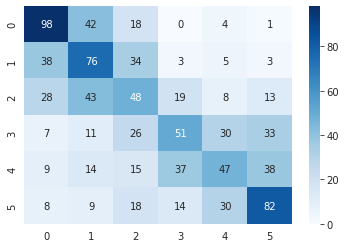

In [ ]:
# Building the confusion matrix to have a look at the model's performance

pipe_SVC = Pipeline([('vectorizer', vectorizer),
                 ('classifier', lsvc)])
pipe_SVC.fit(X_train, y_train)
y_pred_SVC = pipe_SVC.predict(X_test)

# To plot the confusion matrix
sns.set_style("whitegrid")
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_SVC)), annot=True, cmap='Blues', fmt='.4g')

We now try to submit our model using Linear SVC to Kaggle. The model used is the one that was trained on the whole dataset (X and y) instead of the 80% of the training set to get the higher accuracy results.

This submission gave us our best accuracy result on the Kaggle competition (47.0%)

In [ ]:
# Importing the Linear SVC accuracy to Kaggle

df_pred_param = pd.read_csv('unlabelled_test_data.csv') # A copy of df_pred

df_pred_param['difficulty'] = pipe_.predict(df_pred_param['sentence'])
convert_difficulty(df_pred_param, reverse=True)
df_pred_param.pop('sentence')
df_pred_param.to_csv('UNIL_Apple_param_submission.csv',index=False)

In [ ]:
# Create the summary dataframe and sort from better accuracy to worse
results_other_methods = pd.DataFrame([data_cleaning_token,
                                      data_cleaning_search_CV,
                                      data_cleaning_OvR_grid_search,
                                      report_SVC])
results_other_methods.sort_values(by='accuracy', ascending=False)

,model,accuracy,precision,recall,f1_score
0,Logistic Regression with Data Cleaning,0.468750,0.449367,0.446541,0.447950
1,Logistic Regression with Data Cleaning & Searc...,0.460417,0.448052,0.433962,0.440895
2,Logistic Regression with OvR,0.433333,0.389262,0.364780,0.376623
3,Linear SVC,0.418750,0.389744,0.477987,0.429379


### 4. Results Summary

After trying different methods and models with the goal of founding the best accuracy, here is a summary of the results that we found. 

In [ ]:
import matplotlib.pyplot as plt

# In order to compare more easily the accuracy, the functions bewlow will plot the different accuracy that we had in the different models.

def accuracy_comparison_plot(data, title, colors, legend_labels=None):
    # Sort the data frame by the accuracy column
    data = data.sort_values(by='accuracy', ascending=True)

    # Extract the model names and accuracy values from the sorted data frame
    model_names = data['model']
    accuracies = data['accuracy']*100

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(14, 10))

    # Set the background color of the figure to grey
    fig.set_facecolor('#383838')
    ax.set_facecolor('#383838')

    # Set the bars colours
    bars = ax.barh(model_names, accuracies, linewidth=0, color=colors)

    # Set the labels and title
    ax.set_ylabel('Model', fontsize=16, fontweight='bold', color='white')
    ax.set_xlabel('Accuracy (in %)', fontsize=16, fontweight='bold', color='white')
    ax.set_title(title, fontsize=18, fontweight='bold', color='white')

    # Set the legend if provided
    if legend_labels:
        ax.legend(handles=[bars[-5:],bars[:-2]],
                  labels=legend_labels,
                  bbox_to_anchor=(1,0.3),
                  fontsize=14,
                  title='Legend')

    # Remove the border lines of the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set the color of the text for both axis
    ax.tick_params(axis='both', which='both', colors='white', labelsize=14)

    # grid of the plot
    ax.grid(axis='both', color='white', linewidth=0.1)

    # Set the x-axis limits
    ax.set_xlim(0, 50)

    # Show the plot
    plt.show()

##### 5.1. Result summary of the model accuracy without data cleaning

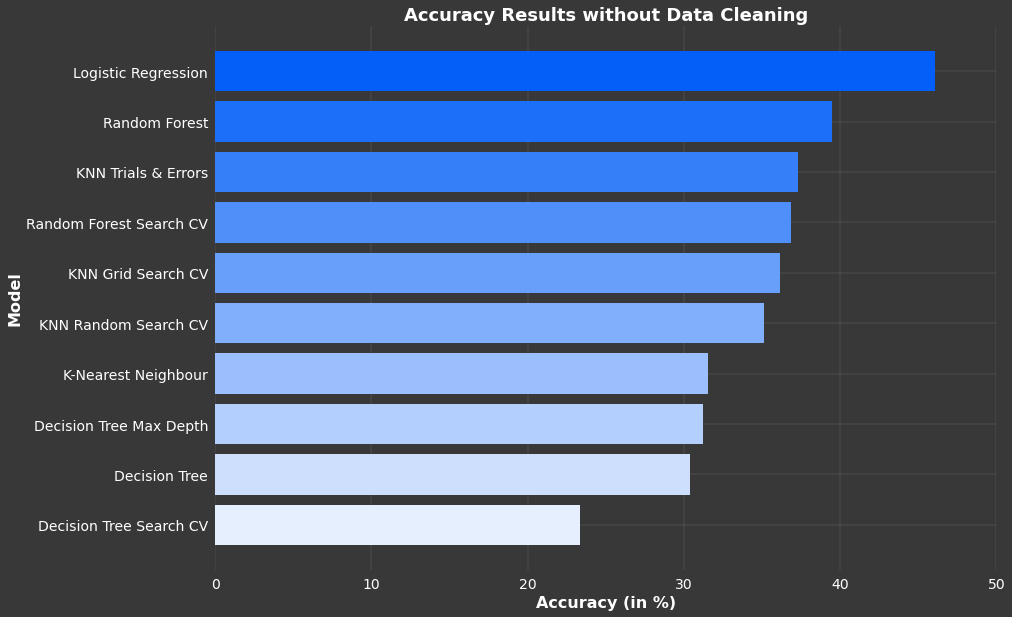

In [ ]:
# For the comparison plot without data cleaning
colors = ['#e6effe','#cddffd','#b3cffd','#9abffc','#81affb','#689ffa','#4f8ff9','#357ff9','#1c6ff8','#035ff7']
title = 'Accuracy Results without Data Cleaning'
data = results_no_data_cleaning

# Calling the function
accuracy_comparison_plot(data, title, colors)

Conclusion of the models accuracy without data cleaning:

From the 4 different regression models that we tried, the best accuracy was found with the logistic model, this could be explained because of:

- **The model complexity:** Logistic Regression is a relatively simple model, and it may be easier to train and more resistant to overfitting than some of the more complex models like Random Forests or Decision Trees that we used. As our dataset is relatively small and has few features, Logistic Regression may perform better than more complex models.

- **The dataset itself:** it's possible that the features in your dataset are better suited for logistic regression than for the other models. It's worth exploring the relationships between the features and the target variable to see if this might be the case.

- **The hyperparameter tuning of the other models:** they might be a way to have a better accuracy from the 3 other models by finding beter parameters. The Grid and Random Search with Cross-Validation might not be the best results possible and we need to find another way to have the best parameters. 

##### 5.2. Result summary of the whole project

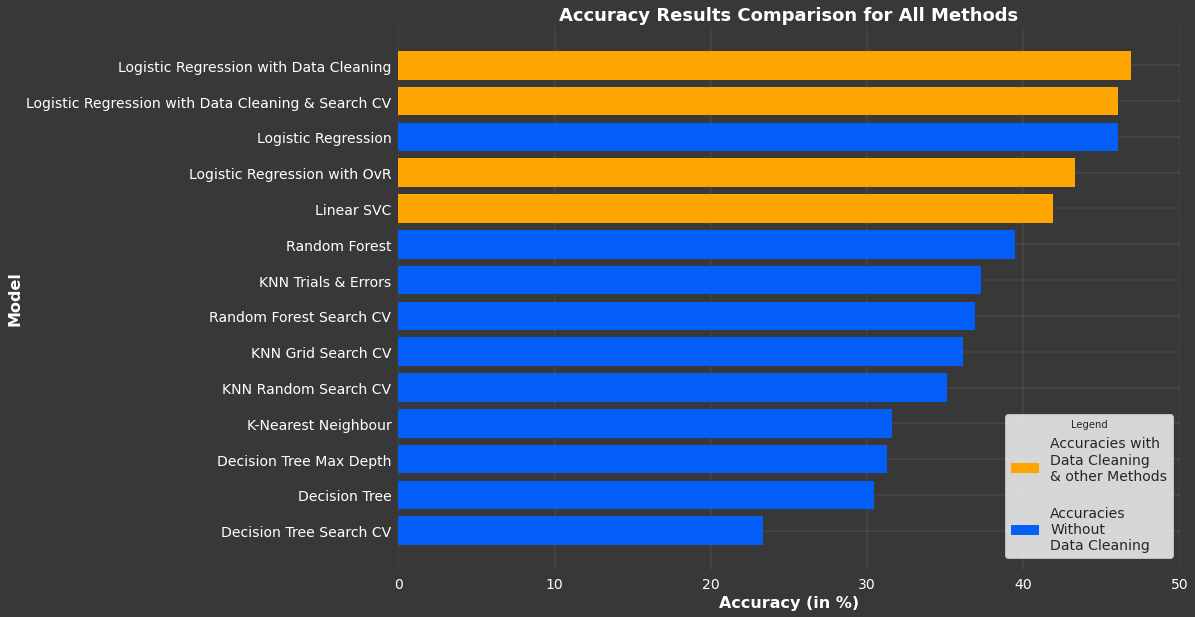

In [ ]:
# For the whole comparison plot

# Combine the 2 result dataframes
plot_all = pd.concat([results_no_data_cleaning, results_other_methods])

# Set the plot parameters
colors = ['#035ff7']*9+['orange']*2+['#035ff7']+['orange']*2
title = 'Accuracy Results Comparison for All Methods'
data = plot_all
legend_labels = ['Accuracies with\nData Cleaning\n& other Methods\n',
                 'Accuracies\nWithout\nData Cleaning']

# Calling the function
accuracy_comparison_plot(data, title, colors, legend_labels)

### 5. Project Conclusion & Feedback 

To conclude this project, we would like to return to some key points. First, it was very interesting to build a model from scratch, having to think about which tools to use and which method to use was very instructive for this course. The organisation of the code was also very instructive, for example, creating functions to avoid redundancy, or using explicit function names, to make the code easier to understand for ourselves and for others who might read it.

Secondly, we would like to come back to some difficulties we encountered. Indeed, the difficulty predictions of a text on which the training set was created surely had its own biases. It was therefore difficult to reproduce a model of our own that could fit exactly the requirements of the basic model. Moreover, the training set had little data to train a powerful machine learning model. As it is often said when talking about machine learning, the more training data there is, the better the machine learning model will be.